# Simulating noise models

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import scipy.stats
import scipy.special
import sys
sys.path.insert(0, '../../')
import mwc.bayes
import mwc.viz
import tqdm
import mwc.model
import imp
import seaborn as sns
imp.reload(mwc.viz)
colors = mwc.viz.personal_style()
%matplotlib inline
np.random.seed(666)

In this notebook, w will simulate the dilution expeirment under a variety of conditions which impose noise on the measurement. T 

## Noise-free  

In [2]:
# Set up parameters
num_div = 100
alpha_true = 150

# Set the protein number range.
prot_range = np.arange(10, 1000, 5)

# Set up a dataframe.
dfs = []
cols = ['summed', 'fluct', 'n1', 'n2', 'ntot']
for i, ntot in enumerate(prot_range):
    n1 = np.random.binomial(ntot, p=0.5, size=num_div)
    n2 = ntot - n1
    summed = alpha_true * ntot
    fluct = (alpha_true * n1 - alpha_true * n2)**2
    copy_dict = dict(summed=summed, fluct=fluct, n1=n1, n2=n2, ntot=ntot)
    df = pd.DataFrame(np.array([np.ones(num_div) * summed, fluct, n1, n2,
                                np.ones(num_div) * ntot]).T, columns=cols)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

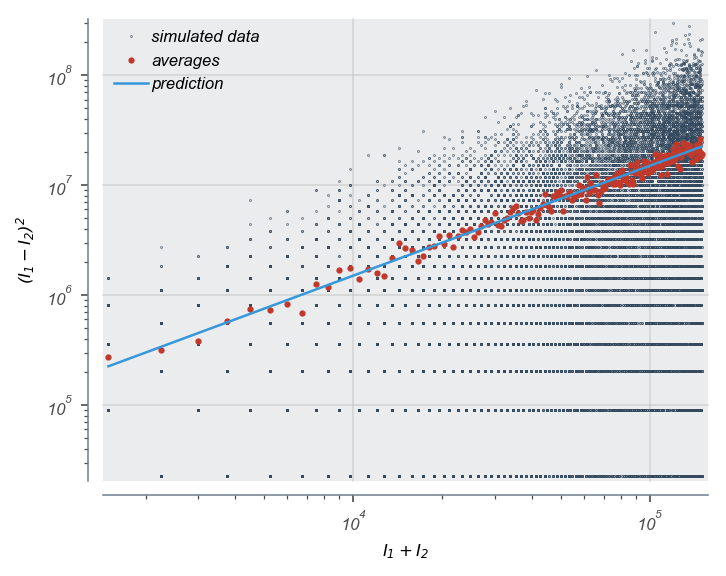

In [3]:
# Compute and plot the averages
grouped = df.groupby('ntot').mean()

# Compute the theory
theory = alpha_true * (alpha_true * prot_range)
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('$I_1 + I_2$')
ax.set_ylabel('$(I_1 - I_2)^2$')
_ = ax.plot(df['summed'], df['fluct'], '.', ms=0.5, label='simulated data')
_ = ax.plot(grouped['summed'], grouped['fluct'], '.', ms=4, label='averages')
_ = ax.plot(alpha_true * prot_range, theory, label='prediction')
_ = ax.legend()
sns.despine(offset=7)
plt.tight_layout()
# plt.savefig('simulated_dilution_simple.pdf', bbox_inches='tight')

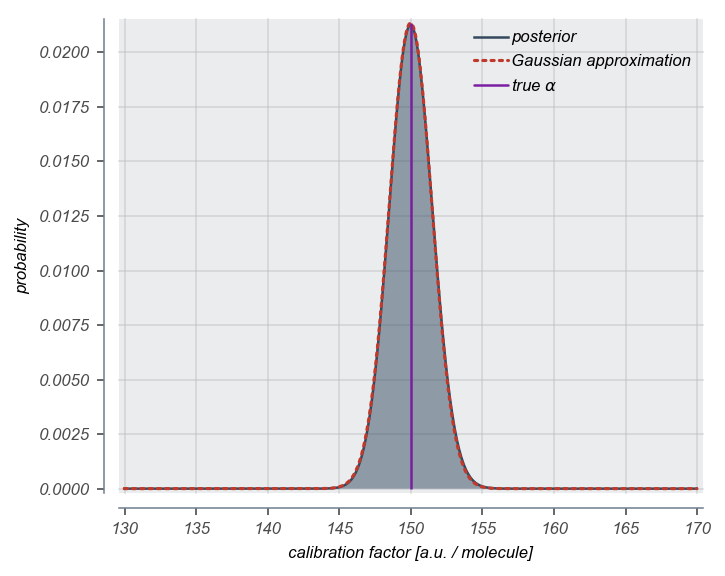

In [4]:
# Estimate parameter through minimization, compute posterior and approximation.
est, err = mwc.bayes.estimate_calibration_factor(
    df['n1'] * alpha_true, df['n2'] * alpha_true)
alpha_range = np.linspace(est - 20, est + 20, 500)
log_post = np.zeros_like(alpha_range)
for i, a in enumerate(alpha_range):
    log_post[i] = mwc.bayes.deterministic_log_posterior(a, df['n1'] * alpha_true,
                                                        df['n2'] * alpha_true)

# Normalize the log posterior and compute.
posterior = np.exp(log_post - scipy.special.logsumexp(log_post))
approx = scipy.stats.norm.pdf(alpha_range, loc=est, scale=err)
approx = approx / np.sum(approx)
# %% Plot the posterior and approximation.
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel('calibration factor [a.u. / molecule]')
ax.set_ylabel('probability')

_ = ax.plot(alpha_range, posterior, label='posterior')
_ = ax.fill_between(alpha_range, posterior, alpha=0.5, label='__nolegend__')
_ = ax.plot(alpha_range, approx, ':', label='Gaussian approximation', lw=1.5)
_ = ax.vlines(alpha_true, np.min(approx),
              np.max(approx), label=r'true $\alpha$', color=colors[4],
              zorder=1000)
_ = ax.legend()
mwc.viz.format_axes()
plt.tight_layout()
# plt.savefig('alpha_simple_minimization.pdf', bbox_inches='tight')

## Examples with real data 

In [5]:
# load in the brewster data. 
brewster = pd.read_csv('../../data/csv/Brewster_et_al_2014_figS3.csv')
binned_data = mwc.stats.bin_by_events(brewster,54)
brewster_opt, brewster_err = mwc.bayes.estimate_calibration_factor(brewster.I_1, brewster.I_2)

# Compute the posterior
alpha_range = np.linspace(140, 200, 500)
log_post = np.zeros_like(alpha_range)
for i, a in enumerate(alpha_range):
    log_post[i] = mwc.bayes.deterministic_log_posterior(a, brewster['I_1'], brewster['I_2'])
posterior = np.exp(log_post - scipy.misc.logsumexp(log_post))


/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


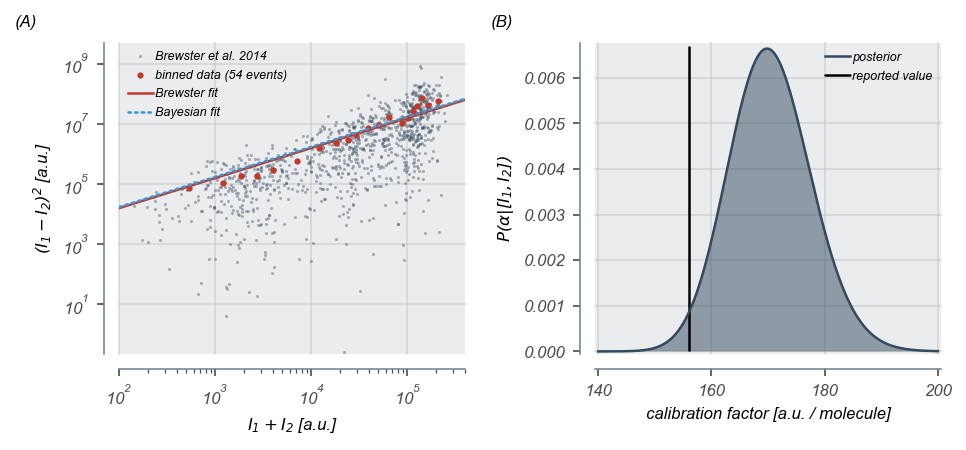

In [6]:
summed_range = np.logspace(0, 6, 500)
brewster_alpha = 156

fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$I_1 + I_2$ [a.u.]')
ax[0].set_ylabel(r'$(I_1 - I_2)^2$ [a.u.]')
ax[1].set_xlabel('calibration factor [a.u. / molecule]')
ax[1].set_ylabel(r'$P(\alpha\vert [I_1, I_2])$')
ax[0].text(-0.3, 1.05, '(A)', fontsize=8, transform=ax[0].transAxes)
ax[1].text(-0.3, 1.05, '(B)', fontsize=8, transform=ax[1].transAxes)


_ = ax[0].plot(brewster.summed,brewster.fluct, '.', ms=1, label='Brewster et al. 2014', alpha=0.4)
_ = ax[0].plot(binned_data['summed'],binned_data['fluct'], '.', ms=4, label='binned data (54 events)')
_ = ax[0].plot(summed_range, brewster_alpha * summed_range, '-', label='Brewster fit', color=colors[1])
_ = ax[0].plot(summed_range, brewster_opt * summed_range, ':', label='Bayesian fit')
ax[0].set_xlim([100, 4E5])
ax[0].set_ylim([ax[0].get_ylim()[0], 5E9])
_ = ax[0].legend(fontsize=6)

_ = ax[1].plot(alpha_range, posterior, label='posterior')
_ = ax[1].fill_between(alpha_range, posterior, alpha=0.5)
_ = ax[1].vlines(brewster_alpha, 0, ax[1].get_ylim()[1], label='reported value')
_ = ax[1].legend(loc='upper right', fontsize=6)

mwc.viz.format_axes()
plt.tight_layout()
plt.savefig('../../figs/brewster_method_agreement.pdf', bbox_inches='tight')

###  Data from my experiments

In [7]:
# Load some data sets. 
hg_data = pd.read_csv('../processing/20180214_hermes_37C_glucose_O2_dilution/output/20180214_hermes_37C_glucose_O2_fluctuations.csv')
led_data = pd.read_csv('../processing/microscopy/20180228_tenjin_37C_glucose_O2_dilution/output/20180228_tenjin_37C_glucose_O2_fluctuations.csv')
laser_data = pd.read_csv('../processing/microscopy/20180119_artemis_37C_glucose_O2_dilution/output/20180119_artemis_37C_glucose_O2_fluctuations.csv')
hg_fc = pd.read_csv('../processing/20180214_hermes_37C_glucose_O2_dilution/output/20180214_hermes_37C_glucose_O2_foldchange.csv')
led_fc = pd.read_csv('../processing/microscopy/20180228_tenjin_37C_glucose_O2_dilution/output/20180228_tenjin_37C_glucose_O2_foldchange.csv')
laser_fc = pd.read_csv('../processing/microscopy/20180119_artemis_37C_glucose_O2_dilution/output/20180119_artemis_37C_glucose_O2_foldchange.csv')



# Bin the data and estimate the calibration factors. 
binned_hg = mwc.stats.bin_by_events(hg_data, 60)
binned_led = mwc.stats.bin_by_events(led_data, 100)
binned_laser = mwc.stats.bin_by_events(laser_data, 60)

hg_opt, hg_err = mwc.bayes.estimate_calibration_factor(hg_data['I_1'], hg_data['I_2'])
led_opt, led_err = mwc.bayes.estimate_calibration_factor(led_data['I_1'], led_data['I_2'])
laser_opt, laser_err = mwc.bayes.estimate_calibration_factor(laser_data['I_1'], laser_data['I_2'])

# Compute the fits. 
hg_summed_range = np.logspace(np.log10(np.min(hg_data['summed']) - 1), np.log10(np.max(hg_data['summed'])) +1, 500)
hg_fit = hg_opt * hg_summed_range
led_summed_range = np.logspace(np.log10(np.min(led_data['summed']) - 1), np.log10(np.max(led_data['summed'])) +1, 500)
led_fit = led_opt * led_summed_range
laser_summed_range = np.logspace(np.log10(np.min(laser_data['summed']) - 1), np.log10(np.max(laser_data['summed'])) +1, 500)
laser_fit = laser_opt * laser_summed_range
                                                                                                                     

# Compute the theoretical fold-change.
rep_range = np.logspace(0, 3, 500)
arch = mwc.model.SimpleRepression(rep_range, -13.9)
fc = arch.fold_change()

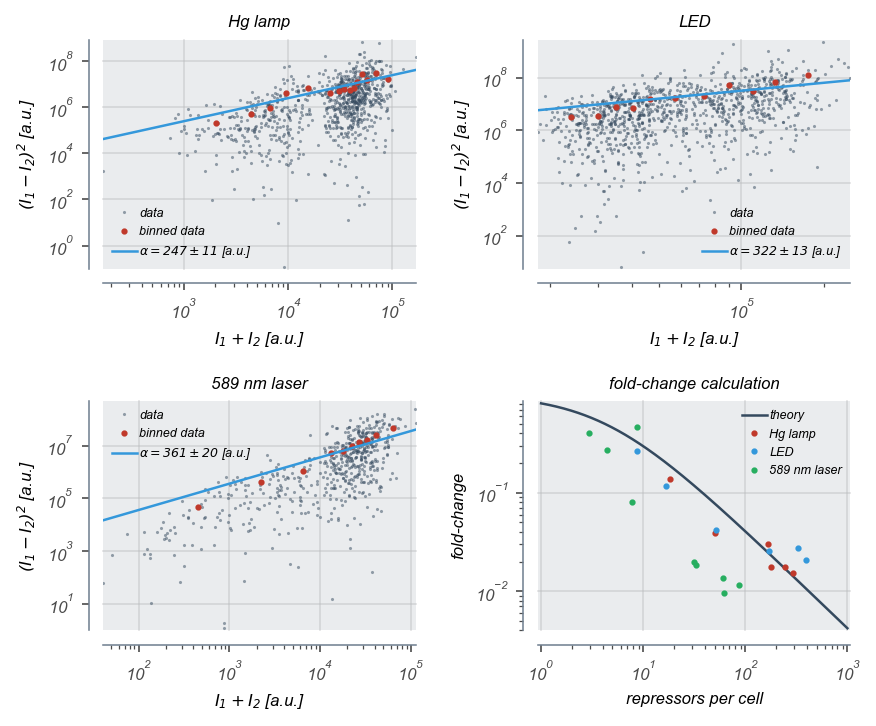

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(6, 5))
ax = ax.ravel()
for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    
for a in ax[:-1]:
    a.set_xlabel('$I_1 + I_2$ [a.u.]')
    a.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')

ax[3].set_xlabel('repressors per cell')
ax[3].set_ylabel('fold-change')
ax[0].set_title('Hg lamp')
ax[1].set_title('LED')
ax[2].set_title('589 nm laser')
ax[3].set_title('fold-change calculation')
_ = ax[0].plot(hg_data['summed'], hg_data['fluct'], '.', ms=1, alpha=0.5, label='data')
_ = ax[0].plot(binned_hg['summed'], binned_hg['fluct'], '.', ms=4, label='binned data')
_ = ax[0].plot(hg_summed_range, hg_fit, '-', label=r'$\alpha = %d \pm %d$ [a.u.]' %(hg_opt, hg_err))
ax[0].set_xlim([np.min(hg_data['summed']), np.max(hg_data['summed'])])
ax[0].legend(fontsize=6, loc='lower left')


_ = ax[1].plot(led_data['summed'], led_data['fluct'], '.', ms=1, alpha=0.5, label='data')
_ = ax[1].plot(binned_led['summed'], binned_led['fluct'], '.', ms=4, label='binned data')
_ = ax[1].plot(led_summed_range, led_fit, '-', label=r'$\alpha = %d \pm %d$ [a.u.]' %(led_opt, led_err))
ax[1].set_xlim([np.min(led_data['summed']), np.max(led_data['summed'])])
ax[1].legend(fontsize=6)

_ = ax[2].plot(laser_data['summed'], laser_data['fluct'], '.', ms=1, alpha=0.5, label='data')
_ = ax[2].plot(binned_laser['summed'], binned_laser['fluct'], '.', ms=4, label='binned data')
_ = ax[2].plot(laser_summed_range, laser_fit, '-', label=r'$\alpha = %d \pm %d$ [a.u.]' %(laser_opt, laser_err))
ax[2].set_xlim([np.min(laser_data['summed']), np.max(laser_data['summed'])])
ax[2].legend(fontsize=6)

_ = ax[3].plot(rep_range, fc, '-', label='theory')
_ = ax[3].plot(hg_fc['mean_repressors'], hg_fc['fold_change'], '.', ms=4, label='Hg lamp')
_ = ax[3].plot(led_fc['mean_repressors'], led_fc['fold_change'], '.', ms=4, label='LED')
_ = ax[3].plot(laser_fc['mean_repressors'], laser_fc['fold_change'], '.', ms=4, label='589 nm laser')
_ = ax[3].legend(fontsize=6)
mwc.viz.format_axes()
plt.tight_layout()
plt.savefig('../../figs/light_source_experiments.pdf', bbox_inches='tight')

## Simple measurement noise

$$
I = \alpha N + \epsilon ; \epsilon \sim \mathcal{N}(0, \sigma_1)
$$

In [127]:
#
noise_range = np.logspace(-3, 2, 500) * alpha_true
alpha_bar = np.empty_like(noise_range)
for j, sigma in enumerate(tqdm.tqdm(noise_range)):
    _df = []
    for n in prot_range:
        n1 = np.random.binomial(n, 0.5, size=num_div)
        n2 = n - n1

        I_1 = alpha_true * n1 + \
            np.random.normal(0, sigma, size=num_div)
        I_2 = alpha_true * n2 + \
            np.random.normal(0, sigma, size=num_div)
        __df = pd.DataFrame(np.array([I_1, I_2]).T, columns=['I_1', 'I_2'])
        _df.append(__df)
    _df = pd.concat(_df, ignore_index=True)
    _df = _df[_df >= 0]

    # Estimate alpha bar via minimization.
    x, s = mwc.bayes.estimate_calibration_factor(_df['I_1'], _df['I_2'])
    alpha_bar[j] = x

100%|██████████| 500/500 [01:56<00:00,  4.30it/s]


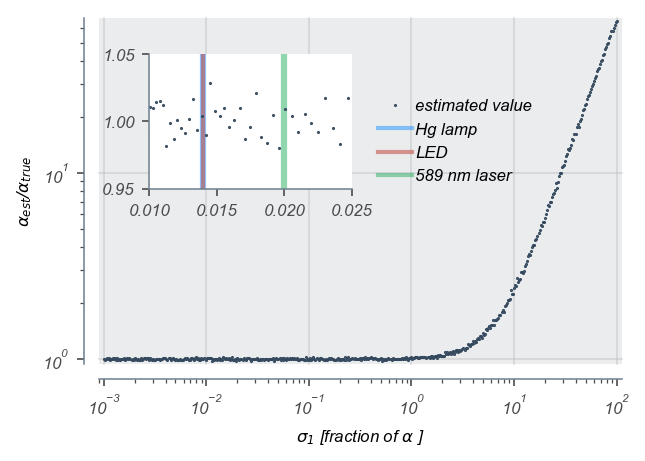

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\sigma_1$ [fraction of $\alpha$ ]')
ax.set_ylabel(r'$\alpha_{est} / \alpha_{true}$')
_ = ax.plot(noise_range / alpha_true, alpha_bar / alpha_true,
            '.', ms=1, label='estimated value')

# # Plot the approximate errors for illumination.
max_height = np.max(alpha_bar / alpha_true)
_ = ax.plot([], [], lw=2, alpha=0.5,
            label='Hg lamp', color='dodgerblue')
_ = ax.plot([], [], lw=2, alpha=0.5, label='LED', color=colors[1])
_ = ax.plot([], [], lw=2, alpha=0.5,
            label='589 nm laser', color=colors[3])
_ = ax.legend(loc='upper right')

# Make the inset.
mwc.viz.format_axes()
ax2 = plt.axes([0.2, 0.5, 0.3, 0.3], facecolor='w')
ax2.plot(noise_range / alpha_true, alpha_bar / alpha_true, '.',
         ms=1)
ax2.set_xlim([0.01, 0.025])
ax2.set_ylim([0.95, 1.05])

max_height = np.max(alpha_bar / alpha_true)
_ = ax2.vlines(0.014, 0.95, 1.05, lw=3, alpha=0.5,
               label='Hg lamp', color='dodgerblue')
_ = ax2.vlines(0.014, 0.95, 1.05, lw=2, alpha=0.5,
               label='LED', color=colors[1])
_ = ax2.vlines(0.02, 0.95, 1.05, lw=3, alpha=0.5,
               label=' 598 nm laser', color=colors[3])
ax2.grid(False)

_ = ax.legend(bbox_to_anchor=(0.85, 0.8))
plt.savefig('../../figs/error_est_model1.pdf', bbox_inches='tight')

##  Model II - Temporal variation in intensity

$$
I =  \phi \alpha N; \phi \sim \mathcal{N}(1, \sigma_2)
$$


In [124]:
noise_range = np.logspace(-4, 2, 500)
alpha_bar = np.empty_like(noise_range)
alpha_err = np.empty_like(noise_range)
for j, sigma in enumerate(noise_range):
    dfs = []
    for i, ntot in enumerate(prot_range):
        n1 = np.random.binomial(ntot, p=0.5, size=num_div)
        n2 = ntot - n1
        phi = np.random.normal(1, sigma, size=num_div)
        I_1 = n1 * alpha_true * phi
        I_2 = n2 * alpha_true * phi
        _df = pd.DataFrame(np.array([I_1, I_2]).T, columns=['I_1', 'I_2'])
        dfs.append(_df)
    _df = pd.concat(dfs, ignore_index=True)

    # Drop negative values for proper estimation.
    _df = _df[_df > 0]

    # Estimate alpha bar via minimization.
    x, s = mwc.bayes.estimate_calibration_factor(_df['I_1'], _df['I_2'])
    alpha_bar[j] = x

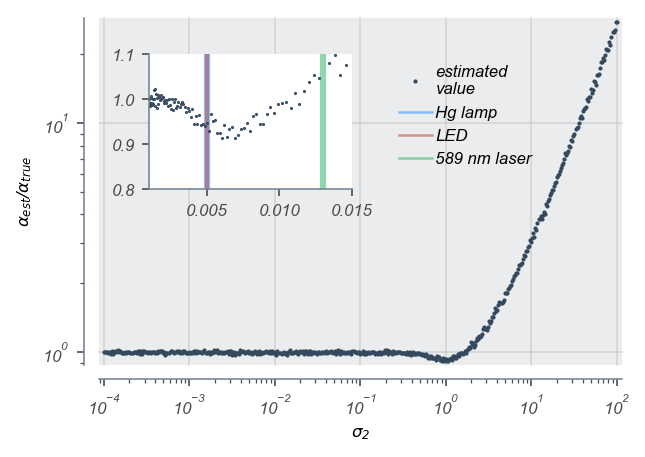

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\sigma_2$')
ax.set_ylabel(r'$\alpha_{est} / \alpha_{true}$')
_ = ax.plot(noise_range, alpha_bar / alpha_true,
            '.', ms=2, label='estimated\nvalue')
mwc.viz.format_axes()

ax.plot([], [], color='dodgerblue', label='Hg lamp', alpha=0.5)
ax.plot([], [], color=colors[1], label='LED', alpha=0.5)
ax.plot([], [], color=colors[3], label='589 nm laser', alpha=0.5)
# Make the inset.
ax2 = plt.axes([0.2, 0.5, 0.3, 0.3], facecolor='w')
ax2.plot(noise_range / alpha_true, alpha_bar / alpha_true, '.',
         ms=1)
ax2.set_xlim([0.001, 0.015])
ax2.set_ylim([0.80, 1.1])

max_height = np.max(alpha_bar / alpha_true)
_ = ax2.vlines(0.005, 0.0, 2, lw=3, alpha=0.5,
               label='Hg lamp', color='dodgerblue')
_ = ax2.vlines(0.005, 0.0, 2, lw=2, alpha=0.5,
               label='LED', color=colors[1])
_ = ax2.vlines(0.013, 0.0, 2, lw=3, alpha=0.5,
               label='laser', color=colors[3])
ax2.grid(False)
_ = ax.legend(bbox_to_anchor=(0.85, 0.9))
plt.savefig('../../figs/err_temporal_variation.pdf', bbox_inches='tight')

##  Model III - Spatial Variation

$$
I = \xi(pos) \alpha N ; \xi(pos) = \begin{cases}\phi(1, \sigma_2) &  pos <=\\  1 & \text{otherwise}\end{cases}
$$

In [85]:
# Size
size = 250
phi_range = [1, 0.999, 0.99, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001, 0]
frac_cells = np.logspace(-3, 0, size)
# alpha_bar = np.empty_like(frac_cells)
alpha_bar = np.zeros((size, len(phi_range)))
# alpha_err = np.empty_like(frac_cells)
for i, p in enumerate(tqdm.tqdm(frac_cells, desc='fraction of cells')):
    for j, k in enumerate(phi_range): 
        dfs = []
        for z, ntot in enumerate(prot_range):
            n1 = np.random.binomial(ntot, p=0.5, size=num_div)
            n2 = ntot - n1
            choices = list(np.where(np.random.rand(num_div) < p)[0])
            I_1 = n1 * alpha_true 
            I_2 = n2 * alpha_true
            if len(choices) > 0:
                I_1[choices] = I_1[choices] * k 
            _df = pd.DataFrame(np.array([I_1, I_2]).T, columns=['I_1', 'I_2'])
            dfs.append(_df)
        _df = pd.concat(dfs, ignore_index=True)

        # Drop negative values for proper estimation.
        _df = _df[_df > 0]

        # Estimate alpha bar via minimization.
        x, s = mwc.bayes.estimate_calibration_factor(_df['I_1'], _df['I_2'])
        alpha_bar[i, j] = x

fraction of cells: 100%|██████████| 250/250 [10:56<00:00,  2.63s/it]


In [89]:
np.shape(alpha_bar)

(250, 10)

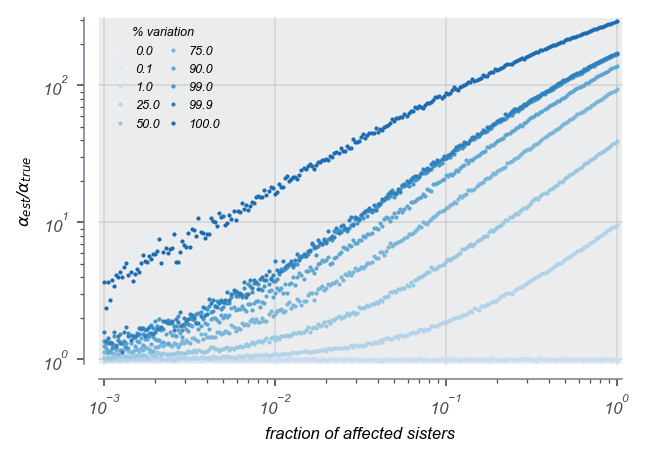

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('fraction of affected sisters')
ax.set_ylabel(r'$\alpha_{est} / \alpha_{true}$')
cmap = sns.color_palette('Blues', n_colors=12)
for i in range(10): 
    _ = ax.plot(frac_cells, alpha_bar[:, i] / alpha_true,
            '.', ms=2, label=r'{0:0.1f}'.format((1 - phi_range[i]) * 100),
               color=cmap[i])
_leg = ax.legend(ncol=2, columnspacing=0.1, title='% variation', fontsize=6)
plt.setp(_leg.get_title().set_fontsize(6))
mwc.viz.format_axes()
plt.savefig('../../figs/err_spatial_variation.pdf', bbox_inches='tight')

In [107]:
ax.legend?

In [93]:
np.shape(alpha_bar)

(250, 10)

In [183]:
from mpl_toolkits.mplot3d import Axes3D

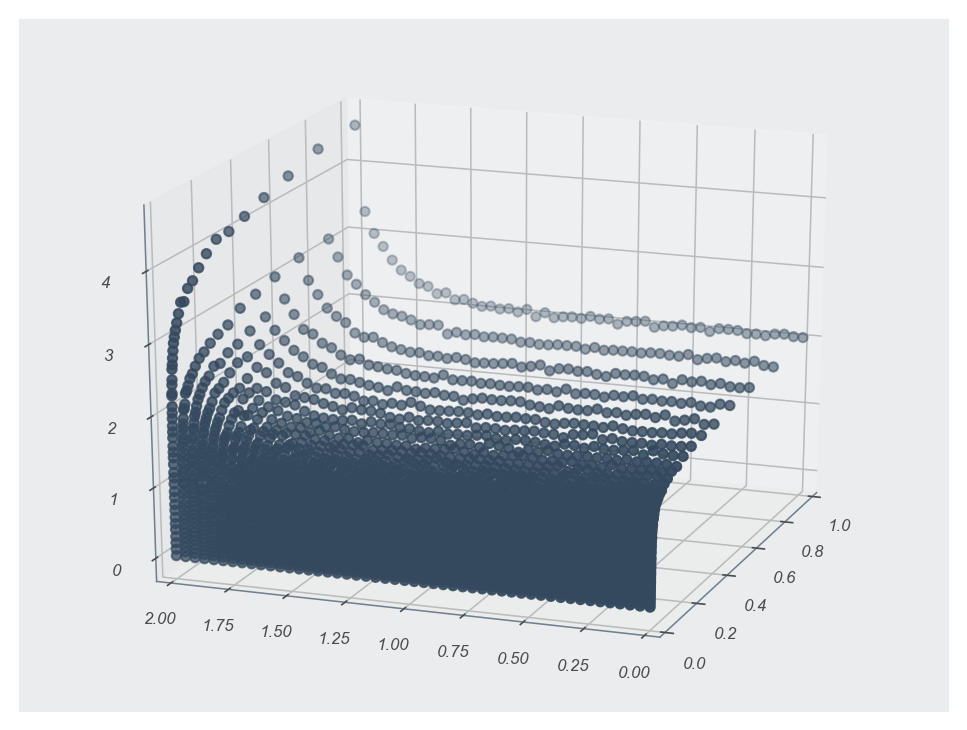

In [205]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(frac_cells, phi_range)

ax.scatter(x, y, alpha_bar / alpha_true, cmap=plt.cm.viridis)
ax.view_init(20, 200)


###  An uncorrelated combination

$$
I = \xi(pos, \sigma_3) \phi(\sigma_2) (\alpha N + \epsilon(\sigma_1))
$$

In [ ]:
alpha_bar